In [135]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

### Use env project_nlp

In [136]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [137]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [138]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [139]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [140]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [141]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [142]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [143]:
from dataaug import SmilesEnumerator

sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1(=O)n(-c2cccc(OCc3ccccc3)c2)nc(OCC)o1
c1(-n2c(=O)oc(OCC)n2)cc(OCc2ccccc2)ccc1
n1(-c2cccc(OCc3ccccc3)c2)c(=O)oc(OCC)n1
c1(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)ccc1
c1ccc(-n2nc(OCC)oc2=O)cc1OCc1ccccc1
c1(OCC)nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1
c1ccc(COc2cc(-n3nc(OCC)oc3=O)ccc2)cc1
c1(OCC)oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1
c1cc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)ccc1
c1(=O)oc(OCC)nn1-c1cc(OCc2ccccc2)ccc1


In [144]:
sme.randomize_smiles(X[0])

'c1cc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)ccc1'

# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [145]:
from datagen import DataGenerator

In [146]:
dgen = DataGenerator(X=X, y=y, seq_length=max_sequence_len, batch_size=32)

In [147]:
len(dgen)

177

In [148]:
len(dgen) * dgen.batch_size


5664

In [149]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

In [150]:
index = 2
batch_size = 128

# Split

In [151]:
from sklearn.model_selection import train_test_split

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
len(X_train), len(y_train), len(X_test)

(4530, 4530, 1133)

In [154]:
X_train

array(['COc1ccc(C(F)(F)F)c[n+]1C.F[B-](F)(F)F',
       '[Cl-].[Cl-].c1cc[n+](COC[n+]2ccccc2)cc1',
       'CCOC(=O)C1=C(C)Oc2nc3c(c(N)c2[C@H]1c1ccccc1)CCCC3', ...,
       'O=[N+]([O-])c1ccccc1-c1nnc(Nc2ncccn2)o1',
       'COc1cc2c(cc1O)CCC(C)(CCNCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2',
       'CN(C)Cc1ccc(CSCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [155]:
# Data Agumenteation solo en train
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [156]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [157]:
X_b.shape

(109, 227)

# Network Model

In [158]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L


In [159]:
# Implementar modelo de TextCNN
def text_cnn_1d_v1(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters,dilation_rates):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    
    embedding = Embedding(vocab_size +1, embedding_size, name='embedding')(input_x)
    
    pooled_outputs = []
    
    # Se puede setear distintos dilatation rates a usar en paralelo
    for dil_rate in dilation_rates:
        for filter_size in filter_sizes:
            conv =  Conv1D(filters = num_filters, kernel_size=filter_size ,padding='same', dilation_rate = dil_rate, activation='relu')(embedding)
            max_p = MaxPool1D(pool_size=2)(conv)
            pooled_outputs.append(max_p)
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = Dense(100, activation='relu')(dense)
    dense = Dense(10, activation='relu')(dense)
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense, name='text_cnn_v1')
    return model

In [160]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)
embeddings_size = 128 
dilation_rates = [1, 2, 3]

In [161]:
model_1 = text_cnn_1d_v1(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS,dilation_rates)
model_1.summary()

Model: "text_cnn_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 128)     5504        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 227, 128)     49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 227, 128)     65664       embedding[0][0]                  
________________________________________________________________________________________

In [162]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [163]:
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])

In [164]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [165]:
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

In [167]:
history = model_1.fit(dgen_train, epochs=500, validation_data=dgen_test,verbose=2,callbacks=[es])

Epoch 1/100
36/36 - 26s - loss: 2.4283 - R2: 0.0744 - val_loss: 2.8303 - val_R2: 0.0547
Epoch 2/100
36/36 - 28s - loss: 2.3741 - R2: 0.0960 - val_loss: 2.7922 - val_R2: 0.0694
Epoch 3/100
36/36 - 27s - loss: 2.3025 - R2: 0.1223 - val_loss: 2.7222 - val_R2: 0.1012
Epoch 4/100
36/36 - 27s - loss: 2.2577 - R2: 0.1363 - val_loss: 2.6842 - val_R2: 0.1075
Epoch 5/100
36/36 - 28s - loss: 2.2057 - R2: 0.1568 - val_loss: 2.6342 - val_R2: 0.1307
Epoch 6/100
36/36 - 29s - loss: 2.1796 - R2: 0.1752 - val_loss: 2.5974 - val_R2: 0.1457
Epoch 7/100
36/36 - 27s - loss: 2.1472 - R2: 0.1783 - val_loss: 2.5708 - val_R2: 0.1474
Epoch 8/100
36/36 - 30s - loss: 2.1079 - R2: 0.2013 - val_loss: 2.5468 - val_R2: 0.1532
Epoch 9/100
36/36 - 31s - loss: 2.1024 - R2: 0.2030 - val_loss: 2.4974 - val_R2: 0.1722
Epoch 10/100
36/36 - 31s - loss: 2.0882 - R2: 0.2071 - val_loss: 2.4486 - val_R2: 0.1912
Epoch 11/100
36/36 - 34s - loss: 2.0602 - R2: 0.2131 - val_loss: 2.4547 - val_R2: 0.1964
Epoch 12/100
36/36 - 31s - los

In [174]:
history = model_1.fit(dgen_train, epochs=200, validation_data=dgen_test,verbose=2,callbacks=[es])

Epoch 1/200
36/36 - 27s - loss: 1.2686 - R2: 0.5185 - val_loss: 1.7753 - val_R2: 0.3947
Epoch 2/200
36/36 - 27s - loss: 1.2892 - R2: 0.5123 - val_loss: 1.7063 - val_R2: 0.4343
Epoch 3/200
36/36 - 27s - loss: 1.2594 - R2: 0.5235 - val_loss: 1.6660 - val_R2: 0.4549
Epoch 4/200
36/36 - 31s - loss: 1.2679 - R2: 0.5140 - val_loss: 1.6798 - val_R2: 0.4430
Epoch 5/200
36/36 - 27s - loss: 1.3013 - R2: 0.5048 - val_loss: 1.7550 - val_R2: 0.4217
Epoch 6/200
36/36 - 24s - loss: 1.2650 - R2: 0.5199 - val_loss: 1.7044 - val_R2: 0.4376
Epoch 7/200
36/36 - 24s - loss: 1.2533 - R2: 0.5259 - val_loss: 1.7013 - val_R2: 0.4405
Epoch 8/200
36/36 - 29s - loss: 1.2525 - R2: 0.5294 - val_loss: 1.6444 - val_R2: 0.4514
Epoch 9/200
36/36 - 30s - loss: 1.2868 - R2: 0.5101 - val_loss: 1.6821 - val_R2: 0.4501
Epoch 10/200
36/36 - 30s - loss: 1.2448 - R2: 0.5259 - val_loss: 1.6305 - val_R2: 0.4466
Epoch 11/200
36/36 - 27s - loss: 1.2188 - R2: 0.5351 - val_loss: 1.6386 - val_R2: 0.4625
Epoch 12/200
36/36 - 25s - los

In [175]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [176]:
X_test_eval.shape, y_test.shape

((1133, 227), (1133,))

In [177]:
y_pred = model_1.predict(X_test_eval)

# Score

In [178]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.607300306702104

In [179]:
filename = 'models/embed_128_text_cnn_aug_100x100_0.0001.h5'
model_1.save(filename)

In [180]:
model_1.summary()

Model: "text_cnn_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 128)     5504        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 227, 128)     49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 227, 128)     65664       embedding[0][0]                  
________________________________________________________________________________________

# Load model (solo si se grabo el modelo)

In [181]:
from tensorflow.keras.models import load_model

In [182]:
filename = 'models/embed_128_text_cnn_aug_100x100_0.0001.h5'
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [183]:
y_pred = model_loaded.predict(X_test_eval)

In [184]:
print(y_pred[0:5].reshape(1,-1))
print(y_t_eval[0:5])

[[7.2714562 5.336411  5.8941917 6.4303513 4.786689 ]]
[7.0835460514500745, 7.148130399270234, 5.823908740944319, 3.6989700043360183, 6.886056647693163]


In [185]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.607300306702104

# Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

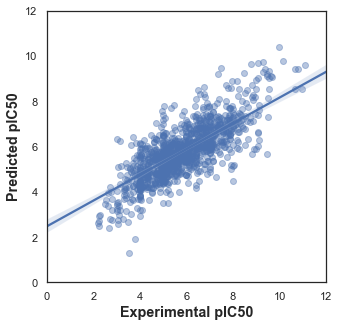

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

## Embeding 128 - dilation_rates = [1] - no callback - epoch 50 - val_R2: 0.2675